---
# House Rent Prediction
---

#### Check out the Dataset-Glossory.txt and readme.md file

| Column Name       | Description                                                |
|-------------------|------------------------------------------------------------|
| BHK               | Number of Bedrooms, Hall, Kitchen                          |
| Rent              | Rent of the Houses/Apartments/Flats                        |
| Size              | Size of the Houses/Apartments/Flats in Square Feet         |
| Floor             | Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.) |
| Area Type         | Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area |
| Area Locality     | Locality of the Houses/Apartments/Flats                   |
| City              | City where the Houses/Apartments/Flats are Located        |
| Furnishing Status | Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished |
| Tenant Preferred  | Type of Tenant Preferred by the Owner or Agent            |
| Bathroom          | Number of Bathrooms                                       |
| Point of Contact  | Whom should you contact for more information regarding the Houses/Apartments/Flats |

### Import Libraries

In [127]:
import os
import math
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import statistics

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
import tensorflow as tf
from sklearn import metrics
from scipy.stats import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [128]:
hd = pd.read_csv('House_Rent_Dataset.csv')
print("(rows, columns) :", hd.shape)
hd.sample(5)

(rows, columns) : (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
3919,2022-05-25,1,5500,300,Ground out of 3,Super Area,Ameenpur,Hyderabad,Unfurnished,Bachelors/Family,1,Contact Owner
80,2022-06-01,3,14500,1800,Ground out of 2,Super Area,Belghoria,Kolkata,Semi-Furnished,Bachelors/Family,2,Contact Owner
2279,2022-07-07,1,8500,300,2 out of 3,Super Area,Bommanahalli,Bangalore,Semi-Furnished,Bachelors/Family,1,Contact Owner
2460,2022-05-18,1,5000,25,2 out of 5,Carpet Area,Ganga Vihar,Delhi,Unfurnished,Bachelors/Family,1,Contact Owner
641,2022-05-14,2,35000,700,5 out of 8,Carpet Area,"MUKTA MAHEK, Thakur Complex",Mumbai,Unfurnished,Family,2,Contact Agent


In [129]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [130]:
# hd.isnull().sum()
# No null values

### Dealing with Outliers

In [131]:
def var_summary(x):
# UC = MEAN + 2 STD
    uc = x.mean()+(2*x.std())
    lc = x.mean()-(2*x.std())
    
    for i in x:
        if i<lc or i>uc:
            count = 1             # This means that column is having an OUTLier
        else:
            count = 0             # That column in not having an outliers
            
    outlier_flag = count
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), 
                      x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),x.quantile(0.10),
                      x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                      x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max() , 
                      lc , uc,outlier_flag],
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 
                         'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,
                         'MAX','LC','UC','outlier_flag'])

In [132]:
numeric_cols = []
for cols in hd:
    if hd[cols].dtypes == 'int64':
        numeric_cols.append(cols)
        
print(numeric_cols)

['BHK', 'Rent', 'Size', 'Bathroom']


In [133]:
hd[numeric_cols].apply(lambda x: var_summary(x))

,BHK,Rent,Size,Bathroom
N,4746.000000,4.746000e+03,4.746000e+03,4746.000000
NMISS,0.000000,0.000000e+00,0.000000e+00,0.000000
SUM,9890.000000,1.660789e+08,4.591711e+06,9330.000000
MEAN,2.083860,3.499345e+04,9.674907e+02,1.965866
MEDIAN,2.000000,1.600000e+04,8.500000e+02,2.000000
STD,0.832256,7.810641e+04,6.342023e+02,0.884532
VAR,0.692650,6.100612e+09,4.022126e+05,0.782396
MIN,1.000000,1.200000e+03,1.000000e+01,1.000000
P1,1.000000,4.000000e+03,7.000000e+01,1.000000
P5,1.000000,6.000000e+03,2.000000e+02,1.000000


#### Nah I dont believe this, lets plot the taget variable

<Axes: xlabel='Rent'>

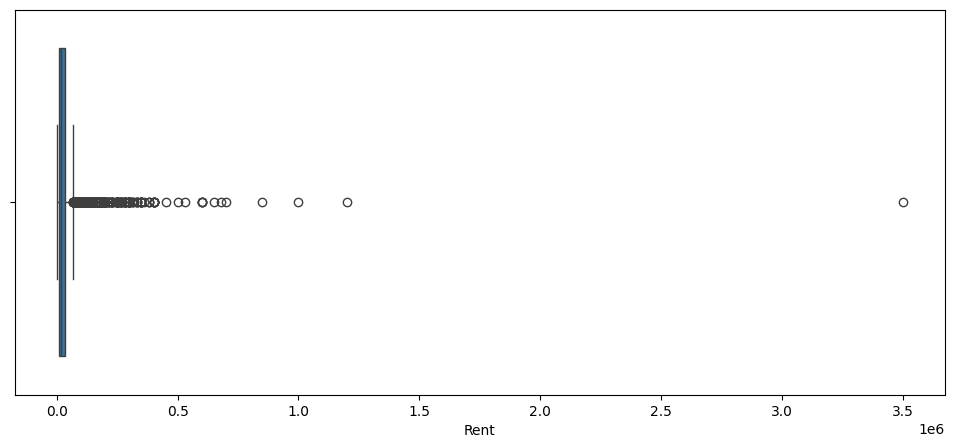

In [134]:
plt.figure(figsize=(12,5))
sns.boxplot(data = hd, x = 'Rent')

In [135]:
hd = hd[hd['Rent'] <= 200000]

<Axes: xlabel='Rent'>

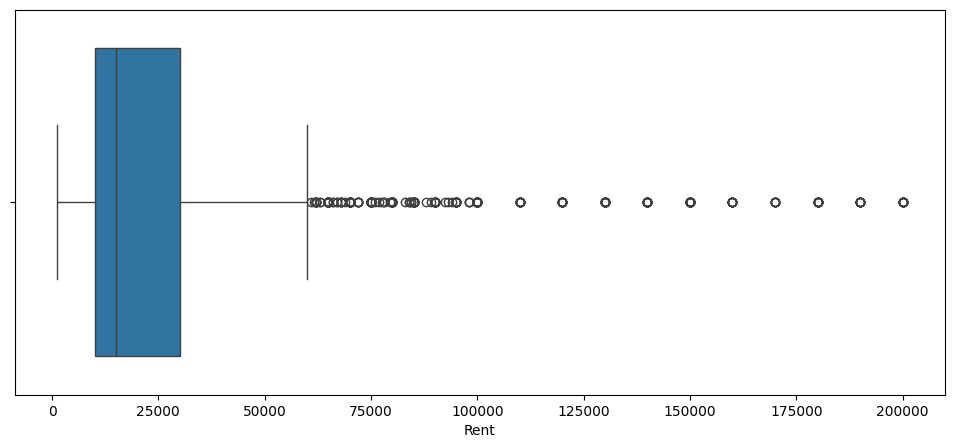

In [136]:
plt.figure(figsize=(12,5))
sns.boxplot(data = hd, x = 'Rent')

### Data Visualization

<Axes: xlabel='City', ylabel='Rent'>

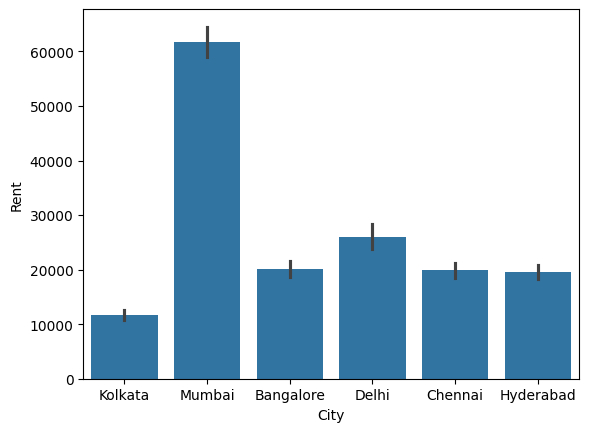

In [137]:
sns.barplot(data = hd, x = 'City', y = 'Rent')
# It seems that Mumbai has the highest Rent amongst all other 

In [138]:
hd['Area Type'].value_counts()

Area Type
Super Area     2436
Carpet Area    2209
Built Area        2
Name: count, dtype: int64

<Axes: xlabel='City', ylabel='Rent'>

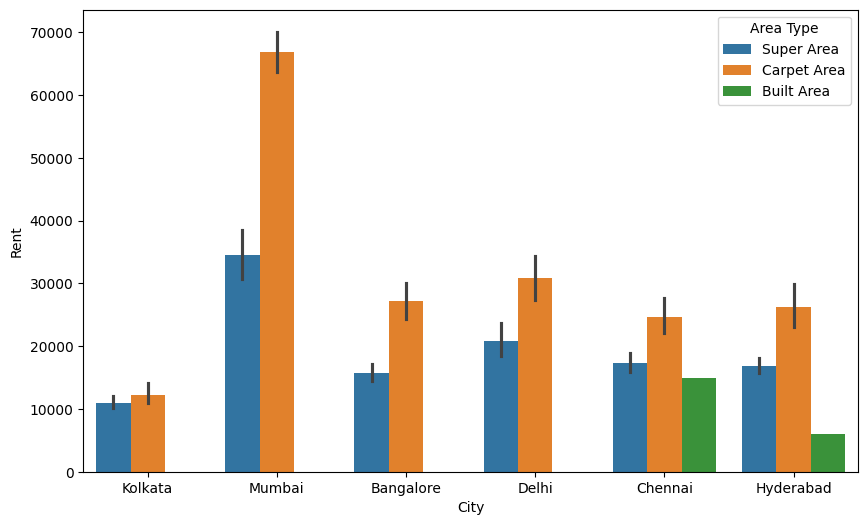

In [139]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Area Type')

<Axes: xlabel='City', ylabel='Rent'>

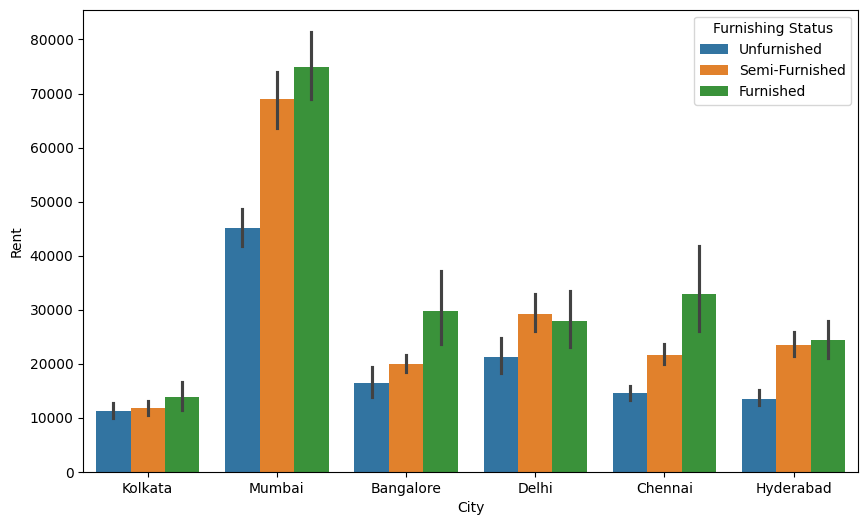

In [140]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Furnishing Status')

<Axes: xlabel='City', ylabel='Rent'>

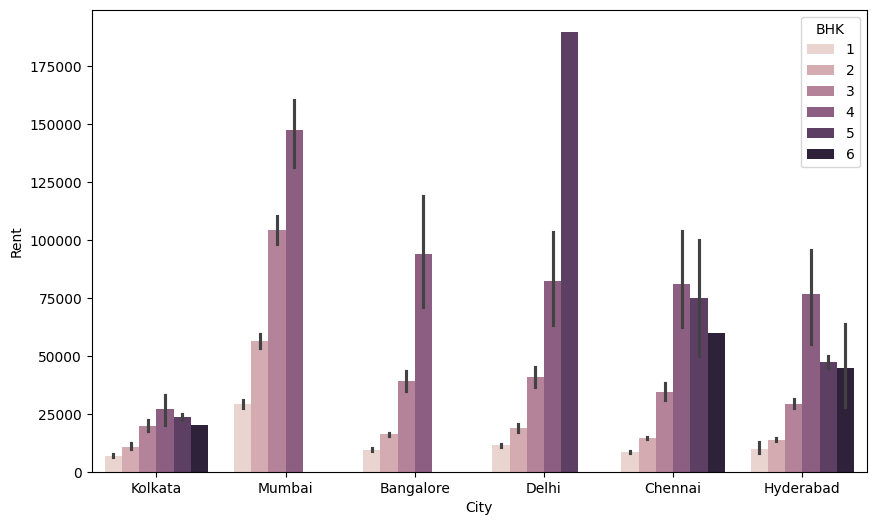

In [141]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'BHK')
# sns.barplot(data = hd, x = 'City', y = 'Rent', hue = hd['BHK'].astype(str))

In [142]:
hd[hd['BHK'] == 6]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
83,2022-06-21,6,20000,1000,1 out of 1,Super Area,Sonarpur,Kolkata,Semi-Furnished,Bachelors/Family,2,Contact Owner
3584,2022-06-02,6,60000,1800,1 out of 3,Super Area,Besant Nagar,Chennai,Furnished,Bachelors/Family,6,Contact Owner
4350,2022-06-18,6,60000,2800,Ground out of 3,Super Area,"Boduppal, NH 2 2",Hyderabad,Furnished,Bachelors/Family,7,Contact Owner
4479,2022-07-07,6,20000,2400,Ground out of 1,Super Area,"Mallikarjuna Nagar, Secunderabad",Hyderabad,Unfurnished,Family,4,Contact Owner
4518,2022-05-12,6,35000,3400,Ground out of 2,Super Area,Rampally,Hyderabad,Unfurnished,Bachelors/Family,7,Contact Owner
4648,2022-07-06,6,80000,4500,1 out of 2,Super Area,"Kakateeya Nagar, Secunderabad",Hyderabad,Semi-Furnished,Bachelors/Family,6,Contact Owner
4696,2022-07-06,6,30000,4200,Ground out of 2,Super Area,Kuntloor,Hyderabad,Semi-Furnished,Bachelors/Family,5,Contact Owner


<Axes: xlabel='City', ylabel='Rent'>

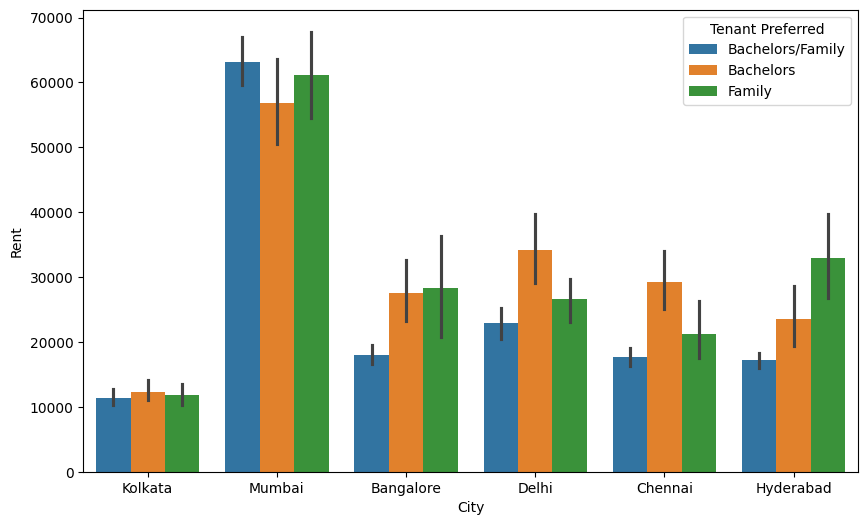

In [143]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Tenant Preferred')

### Data Preprocessing 

In [144]:
# LMAO, WHAT ARE WE GONNA DO WITH 5-10 BATHROOMS
hd['Bathroom'].value_counts()

Bathroom
2     2285
1     1474
3      732
4      116
5       28
6        8
7        3
10       1
Name: count, dtype: int64

In [145]:
valid_bathrooms = [1, 2, 3, 4]
hd = hd[hd['Bathroom'].isin(valid_bathrooms)]

<Axes: xlabel='City', ylabel='Rent'>

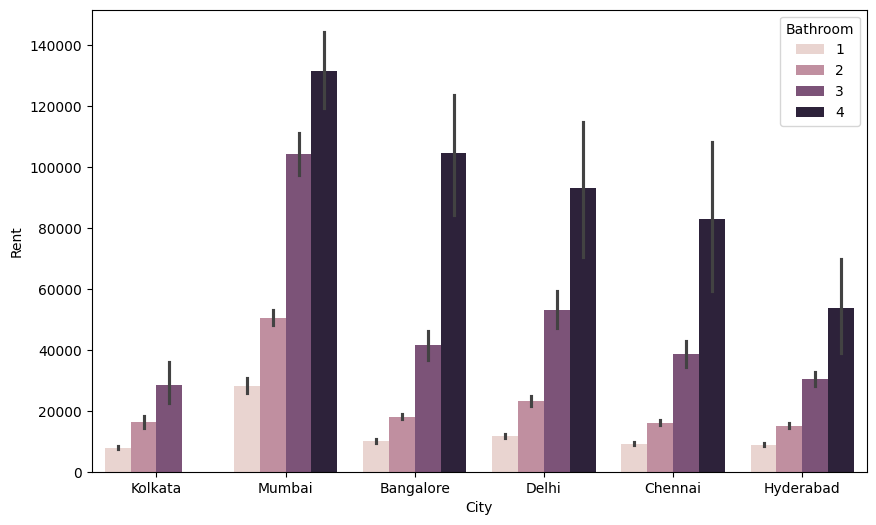

In [146]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Bathroom')

In [147]:
hd['Bathroom'].value_counts()

Bathroom
2    2285
1    1474
3     732
4     116
Name: count, dtype: int64

In [148]:
# Les drop 5 and 6 BHK, cause they arent contributing that much.
hd['BHK'].value_counts()

BHK
2    2261
1    1166
3    1065
4     109
5       4
6       2
Name: count, dtype: int64

In [149]:
valid_rooms = [1, 2, 3, 4]
hd = hd[hd['BHK'].isin(valid_rooms)]

<Axes: xlabel='City', ylabel='Rent'>

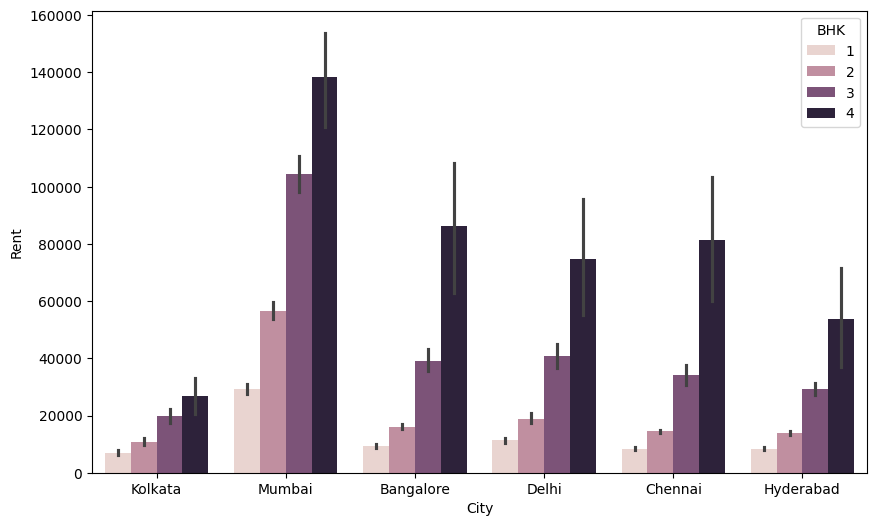

In [150]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'BHK')

In [151]:
hd['BHK'].value_counts()

BHK
2    2261
1    1166
3    1065
4     109
Name: count, dtype: int64

In [152]:
hd.sort_values(by='Rent', ascending=False)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
2755,2022-05-16,4,200000,2700,Ground out of 3,Carpet Area,Greater Kailash 1,Delhi,Unfurnished,Bachelors,4,Contact Agent
798,2022-07-06,4,200000,1900,5 out of 11,Carpet Area,"Dheeraj Insignia Apartment, Bandra Kurla Complex",Mumbai,Furnished,Bachelors/Family,3,Contact Agent
788,2022-05-14,3,200000,1208,5 out of 14,Carpet Area,Khar West,Mumbai,Unfurnished,Bachelors,3,Contact Agent
832,2022-07-09,3,200000,1350,1 out of 5,Carpet Area,anjali,Mumbai,Furnished,Bachelors,3,Contact Agent
2577,2022-06-10,4,200000,2300,1 out of 1,Super Area,Shanti Niketan,Delhi,Semi-Furnished,Bachelors/Family,4,Contact Owner
...,...,...,...,...,...,...,...,...,...,...,...,...
146,2022-06-05,2,2200,550,2 out of 3,Super Area,Behala silpara,Kolkata,Furnished,Bachelors/Family,1,Contact Owner
2475,2022-06-22,2,2000,60,1 out of 1,Super Area,Ram Nagar,Delhi,Unfurnished,Bachelors/Family,1,Contact Owner
471,2022-05-12,1,1800,500,Ground out of 1,Super Area,Shyam Bazar,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
285,2022-05-24,1,1500,200,Ground out of 2,Super Area,Santoshpur,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner


In [153]:
(hd['Rent'] == 200000).value_counts()

Rent
False    4590
True       11
Name: count, dtype: int64

In [154]:
# Dropping rows with Rent higher than 150000, and are Unfurnished
hd = hd[(hd['Rent'] <= 150000) | (hd['Furnishing Status'] != 'Unfurnished')]

In [155]:
# Lets consider, some of em might be Bunglows.
hd[hd['Rent'] == 200000]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
798,2022-07-06,4,200000,1900,5 out of 11,Carpet Area,"Dheeraj Insignia Apartment, Bandra Kurla Complex",Mumbai,Furnished,Bachelors/Family,3,Contact Agent
832,2022-07-09,3,200000,1350,1 out of 5,Carpet Area,anjali,Mumbai,Furnished,Bachelors,3,Contact Agent
871,2022-07-09,3,200000,1350,1 out of 5,Carpet Area,Anand niwas,Mumbai,Furnished,Bachelors,3,Contact Agent
1089,2022-05-16,2,200000,1000,7 out of 8,Carpet Area,Union Park,Mumbai,Furnished,Bachelors/Family,2,Contact Agent
1115,2022-07-09,3,200000,1400,8 out of 17,Carpet Area,"Hill Road, Bandra West",Mumbai,Furnished,Bachelors/Family,3,Contact Agent
1392,2022-06-04,3,200000,1375,15 out of 60,Carpet Area,"Raheja Imperia, Worli",Mumbai,Semi-Furnished,Family,3,Contact Agent
2577,2022-06-10,4,200000,2300,1 out of 1,Super Area,Shanti Niketan,Delhi,Semi-Furnished,Bachelors/Family,4,Contact Owner
2990,2022-07-10,3,200000,3000,1 out of 1,Super Area,Madras Boat Club Road,Chennai,Furnished,Family,4,Contact Agent
3639,2022-06-14,4,200000,2280,2 out of 3,Carpet Area,Mylapore,Chennai,Semi-Furnished,Bachelors/Family,4,Contact Agent


Checking if the data got any negative values.

In [156]:
hd[(hd[numeric_cols] < 0).any(axis=1)]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact


In [157]:
hd1 = hd.copy()

In [158]:
hd1.sample(5)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
465,2022-05-10,2,7000,750,2 out of 2,Super Area,Baughati,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
350,2022-05-20,2,6000,960,Ground out of 2,Super Area,Dum Dum,Kolkata,Semi-Furnished,Bachelors/Family,2,Contact Owner
4300,2022-07-08,2,12000,800,Ground out of 6,Super Area,Bandlaguda Jagir,Hyderabad,Unfurnished,Bachelors/Family,2,Contact Owner
4411,2022-06-06,3,22000,1500,3 out of 6,Super Area,Petbasheerabad,Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
3339,2022-06-23,1,12000,650,1 out of 2,Super Area,Triplicane,Chennai,Unfurnished,Bachelors/Family,1,Contact Owner


In [159]:
# Dropping unwanted cols
drop_col = ['Posted On', 'Floor', 'Area Locality', 'Point of Contact']
hd1.drop(columns=drop_col, inplace = True)

In [160]:
hd1 = hd1[hd1['Area Type'] != 'Built Area']

In [161]:
hd1.sample(5)

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
3494,1,8000,700,Super Area,Chennai,Semi-Furnished,Bachelors/Family,1
1685,2,16000,900,Carpet Area,Bangalore,Semi-Furnished,Bachelors/Family,1
4455,2,15000,600,Super Area,Hyderabad,Furnished,Bachelors/Family,2
3005,2,23000,920,Carpet Area,Chennai,Semi-Furnished,Bachelors/Family,2
70,1,7500,680,Super Area,Kolkata,Unfurnished,Bachelors/Family,1


### Data Scaling

In [162]:
print(hd1['Furnishing Status'].unique())
print(hd1['Area Type'].unique())
print(hd1['Tenant Preferred'].unique())

['Unfurnished' 'Semi-Furnished' 'Furnished']
['Super Area' 'Carpet Area']
['Bachelors/Family' 'Bachelors' 'Family']


In [163]:
hd1['Furnishing Status'] = hd1['Furnishing Status'].replace(['Furnished', 'Semi-Furnished','Unfurnished'], [2, 1, 0])
hd1['Area Type'] = hd1['Area Type'].replace(['Super Area','Carpet Area'],[1,0])
hd1['Tenant Preferred'] = hd1['Tenant Preferred'].replace(['Bachelors/Family', 'Bachelors', 'Family'],[2, 1, 0])

In [164]:
print(hd1['Furnishing Status'].unique())
print(hd1['Area Type'].unique())
print(hd1['Tenant Preferred'].unique())

[0 1 2]
[1 0]
[2 1 0]


In [165]:
hd1['City'].unique()

array(['Kolkata', 'Mumbai', 'Bangalore', 'Delhi', 'Chennai', 'Hyderabad'],
      dtype=object)

In [166]:
hd1.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
0,2,10000,1100,1,Kolkata,0,2,2
1,2,20000,800,1,Kolkata,1,2,1
2,2,17000,1000,1,Kolkata,1,2,1
3,2,10000,800,1,Kolkata,0,2,1
4,2,7500,850,0,Kolkata,0,1,1


In [167]:
hd1['City'] = hd1['City'].astype('category')
all_cat = hd1['City'].unique()
encoder = LabelEncoder()
encoder.fit(all_cat)
hd1['City'] = encoder.transform(hd1['City'])

In [168]:
hd1['City'].unique()

array([4, 5, 0, 2, 1, 3])

In [169]:
hd1.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
0,2,10000,1100,1,4,0,2,2
1,2,20000,800,1,4,1,2,1
2,2,17000,1000,1,4,1,2,1
3,2,10000,800,1,4,0,2,1
4,2,7500,850,0,4,0,1,1


Scaling 'Size' Column using MinMax and Standardization and RobustScalar

In [170]:
hd2 = hd1.copy()
hd3 = hd1.copy()

In [171]:
hd2.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
0,2,10000,1100,1,4,0,2,2
1,2,20000,800,1,4,1,2,1
2,2,17000,1000,1,4,1,2,1
3,2,10000,800,1,4,0,2,1
4,2,7500,850,0,4,0,1,1


In [172]:
hd3.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
0,2,10000,1100,1,4,0,2,2
1,2,20000,800,1,4,1,2,1
2,2,17000,1000,1,4,1,2,1
3,2,10000,800,1,4,0,2,1
4,2,7500,850,0,4,0,1,1


In [173]:
scaler1 = MinMaxScaler()
scaler2 = StandardScaler()
scaler3 = RobustScaler()
fin1 = scaler1.fit_transform(hd1[['Size']].values.reshape(-1, 1))
fin2 = scaler2.fit_transform(hd2[['Size']].values.reshape(-1, 1))
fin3 = scaler3.fit_transform(hd3[['Size']].values.reshape(-1, 1))
hd1['Size_MM'] = fin1
hd2['Size_STD'] = fin2
hd3['Size_RBS'] = fin3

In [174]:
hd1.drop(columns=['Size'], inplace = True)
hd2.drop(columns=['Size'], inplace = True)
hd3.drop(columns=['Size'], inplace = True)

In [175]:
hd1.head()

,BHK,Rent,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Size_MM
0,2,10000,1,4,0,2,2,0.227557
1,2,20000,1,4,1,2,1,0.164927
2,2,17000,1,4,1,2,1,0.206681
3,2,10000,1,4,0,2,1,0.164927
4,2,7500,0,4,0,1,1,0.175365


In [176]:
hd2.head()

,BHK,Rent,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Size_STD
0,2,10000,1,4,0,2,2,0.352248
1,2,20000,1,4,1,2,1,-0.215379
2,2,17000,1,4,1,2,1,0.163039
3,2,10000,1,4,0,2,1,-0.215379
4,2,7500,0,4,0,1,1,-0.120775


In [177]:
hd3.head()

,BHK,Rent,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Size_RBS
0,2,10000,1,4,0,2,2,0.456923
1,2,20000,1,4,1,2,1,-0.004615
2,2,17000,1,4,1,2,1,0.303077
3,2,10000,1,4,0,2,1,-0.004615
4,2,7500,0,4,0,1,1,0.072308


### Train-Test Split and Model Training

In [178]:
# X = hd1.drop(columns='Rent')
# y = hd1['Rent']
# X = hd2.drop(columns='Rent')
# y = hd2['Rent']
X = hd3.drop(columns='Rent')
y = hd3['Rent']

#### Finding the best random_state 

In [179]:
random_states = range(1, 201)
best_random_state = None
best_score = -1  # Initialize with a low value (e.g., for R-squared, initialize with -1)
model = GradientBoostingRegressor()

for random_state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    model.fit(X_train, y_train)
    # Evaluate the model using an appropriate metric (e.g., R-squared)
    score = model.score(X_test, y_test)
    # Check if the current random state has a higher score
    if score > best_score:
        best_score = score
        best_random_state = random_state

print(f"Best Random State: {best_random_state}")

Best Random State: 138


In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=best_random_state) # Test with random_state

#### Cross-Validation

In [181]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

# Iterating through each model and performing cross-validation
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)  # Convert negative MSE to RMSE
    mean_rmse = rmse_scores.mean()
    std_rmse = rmse_scores.std()
    print(f"{model_name} RMSE: {mean_rmse:.2f} (+/- {std_rmse:.2f})")
    #                                           ^       ^
    # It represents the amount of variation or spread in RMSE values 

Linear Regression RMSE: 21656.71 (+/- 568.13)
Random Forest RMSE: 16575.62 (+/- 454.73)
Gradient Boosting RMSE: 15290.67 (+/- 709.55)
SVR RMSE: 31316.10 (+/- 815.00)
Lasso RMSE: 21656.67 (+/- 568.20)
Ridge RMSE: 21656.70 (+/- 568.34)
Decision Tree RMSE: 20285.68 (+/- 846.76)
K-Nearest Neighbors RMSE: 17113.07 (+/- 742.18)


--- 

#### Gradient Boosting and Random-Forest seems the best choice
Cross-validation refers to the number of folds or partitions that your dataset is split into for cross-validation. It is commonly known as "k" in k-fold cross-validation. In this case, cv=5 means that your dataset is divided into 5 equal parts, or "folds." <br><br>
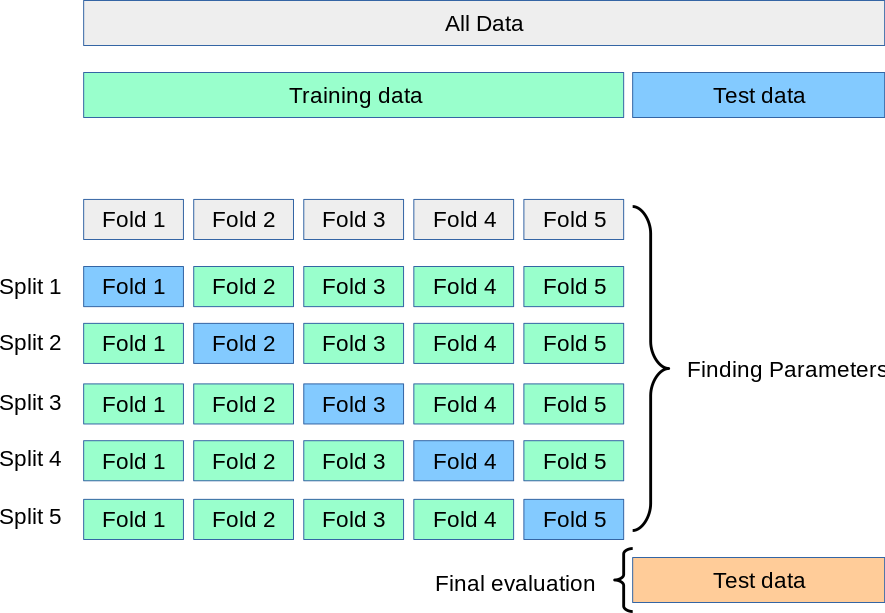
<br><br>

In [182]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [183]:
y_pred = model.predict(X_test)

In [184]:
print(X_train.shape)
print(X_train.shape[1])

(3672, 7)
7


In [185]:
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2S = r2_score(y_test, y_pred)
RMSE = math.sqrt(MSE)
# Adjusted R^2
n = len(y_test)
p = X_train.shape[1] 
ADJ_R2S = 1 - (1 - R2S) * (n - 1) / (n - p - 1)
print("The MSE:", round(MSE,3))
print("The RMSE:", round(RMSE,3))
print("The MAE:", round(MAE,3))
print("The R^2:", round(R2S, 2))
print("The ADJ_R^2:", round(ADJ_R2S, 2))

The MSE: 186464726.412
The RMSE: 13655.209
The MAE: 7683.143
The R^2: 0.81
The ADJ_R^2: 0.81


### Residual Analysis
 If all residuals lie exactly on the red line, it indicates that the model perfectly fits the data, but that doesn't necessarily mean it's the best model. It might be overfitting the data. We want the residuals to be randomly scattered around the red line, showing no clear patterns or trends, which indicates that the model's assumptions (homoscedasticity and normality) are met.

In [186]:
residuals = y_test - y_pred

In [187]:
data = {'Predicted' : y_pred,
           'Residuals' : residuals}
analysis = pd.DataFrame(data)

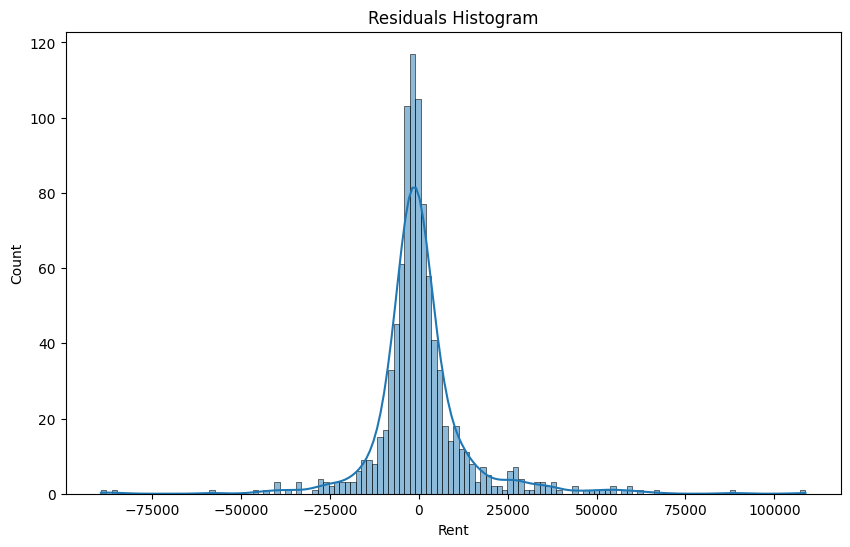

In [188]:
# Check for normality of residuals using a histogram and Q-Q plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Residuals Histogram")
plt.show()

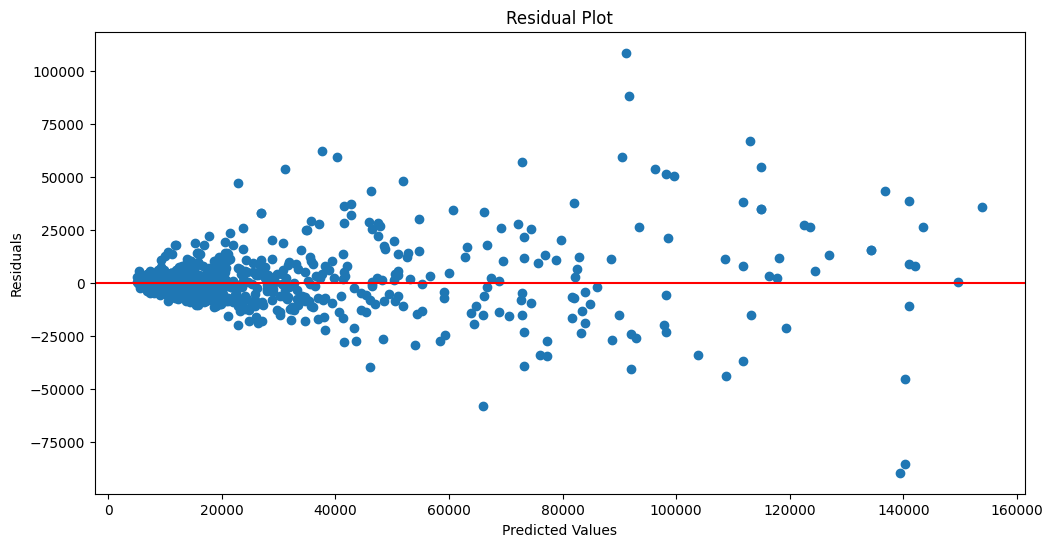

In [189]:
plt.figure(figsize=(12,6))
plt.scatter(y_pred, residuals)
# Setting the red line at y=0
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

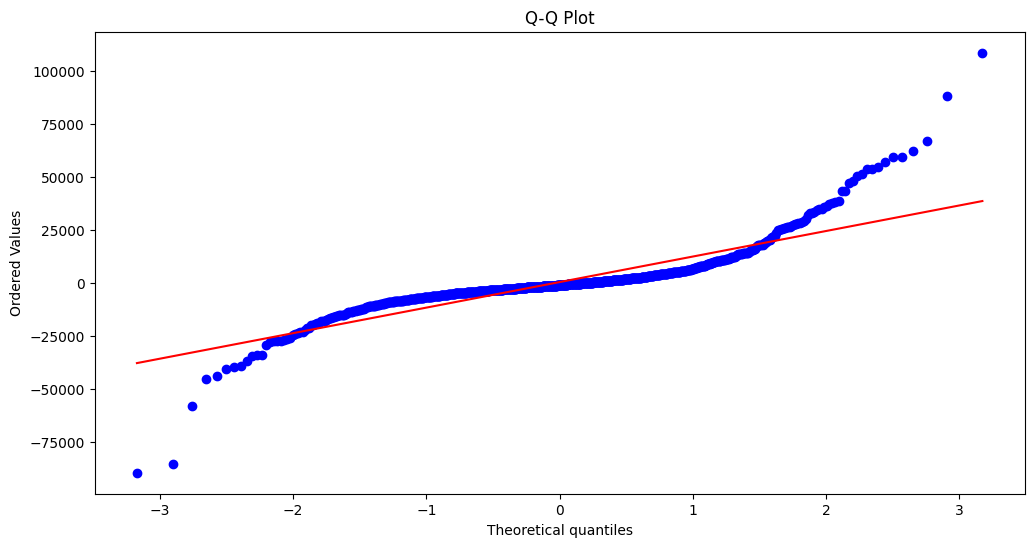

In [190]:
import scipy.stats as stats
import pylab
# Check for normality of residuals using a Q-Q plot
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.title("Q-Q Plot")
pylab.show()

In [191]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2S = r2_score(y_test, y_pred)
RMSE = math.sqrt(MSE)
# Adjusted R^2
n = len(y_test)
p = X_train.shape[1] 
ADJ_R2S = 1 - (1 - R2S) * (n - 1) / (n - p - 1)
print("The MSE:", round(MSE,3))
print("The RMSE:", round(RMSE,3))
print("The MAE:", round(MAE,3))
print("The R^2:", round(R2S, 2))
print("The ADJ_R^2:", round(ADJ_R2S, 2))

The MSE: 205798895.694
The RMSE: 14345.693
The MAE: 7984.618
The R^2: 0.79
The ADJ_R^2: 0.79


### Hyper-Parameter Tuning (on GBR and RF)

#### GBR Hypertuning

In [192]:
parameter_grid_gbr = {
    'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.01, 0.1, 0.2],
}
gbr_model = GradientBoostingRegressor()

In [193]:
grid_search_gbr = GridSearchCV(estimator=gbr_model, param_grid=parameter_grid_gbr,
                          scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
# n_jobs speeds up HP tuning process by leveraging multiple CPU cores for parallel processing.

random_search_gbr = RandomizedSearchCV(estimator=gbr_model, 
                                   param_distributions = parameter_grid_gbr, 
                                   scoring='neg_mean_squared_error' ,cv=5, n_iter=10 ,n_jobs=-1)
# n_iters determines how many random combination of HP will be evaluated during RandomizedSearch

In [194]:
grid_search_gbr.fit(X_train, y_train)
best_parameter1 = grid_search_gbr.best_params_
print(best_parameter1)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [195]:
random_search_gbr.fit(X_train, y_train)
best_parameter2 = random_search_gbr.best_params_
print(best_parameter2)

{'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.01}


In [216]:
# gbr_model = GradientBoostingRegressor(n_estimators=300, max_depth=6, learning_rate=0.01)
gbr_model = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.01)
gbr_model.fit(X_train, y_train)
y_pred = gbr_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2S = r2_score(y_test, y_pred)
RMSE = math.sqrt(MSE)
# Adjusted R^2
n = len(y_test)
p = X_train.shape[1] 
ADJ_R2S = 1 - (1 - R2S) * (n - 1) / (n - p - 1)
print("The MSE:", round(MSE,3))
print("The RMSE:", round(RMSE,3))
print("The MAE:", round(MAE,3))
print("The R^2:", round(R2S, 2))
print("The ADJ_R^2:", round(ADJ_R2S, 2))

The MSE: 190181700.418
The RMSE: 13790.638
The MAE: 7887.832
The R^2: 0.81
The ADJ_R^2: 0.81


#### Random-Forest Hypertuning

In [197]:
parameter_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
rf_model = RandomForestRegressor()

In [198]:
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=parameter_grid_rf, 
                                      n_iter=100, cv=5, scoring='neg_mean_squared_error', 
                                      random_state=42)
# n_iters determines how many random combination of HP will be evaluated during RandomizedSearch

In [199]:
random_search_rf.fit(X_train, y_train)
best_parameter = random_search_rf.best_params_
print(best_parameter)

{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10}


In [208]:
# rf_model = RandomForestRegressor(n_estimators=250, min_samples_split=10, 
#                                  min_samples_leaf=4, max_features=None, max_depth=20)
rf_model = RandomForestRegressor(n_estimators=250, min_samples_split=10, 
                                 min_samples_leaf=4, max_features=None, max_depth=10)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2S = r2_score(y_test, y_pred)
RMSE = math.sqrt(MSE)

n = len(y_test)
p = X_train.shape[1] 
ADJ_R2S = 1 - (1 - R2S) * (n - 1) / (n - p - 1)
print("The MSE:", round(MSE,3))
print("The RMSE:", round(RMSE,3))
print("The MAE:", round(MAE,3))
print("The R^2:", round(R2S, 2))
print("The ADJ_R^2:", round(ADJ_R2S, 2))

The MSE: 192718330.966
The RMSE: 13882.303
The MAE: 7666.037
The R^2: 0.81
The ADJ_R^2: 0.81


#### GB performs well, we'll use this for now

In [217]:
# gbr_model = GradientBoostingRegressor(n_estimators=300, max_depth=6, learning_rate=0.01)
gbr_model = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.01)
gbr_model.fit(X_train, y_train)
y_pred = gbr_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2S = r2_score(y_test, y_pred)
RMSE = math.sqrt(MSE)
# Adjusted R^2
n = len(y_test)
p = X_train.shape[1] 
ADJ_R2S = 1 - (1 - R2S) * (n - 1) / (n - p - 1)
print("The MSE:", round(MSE,3))
print("The RMSE:", round(RMSE,3))
print("The MAE:", round(MAE,3))
print("The R^2:", round(R2S, 2))
print("The ADJ_R^2:", round(ADJ_R2S, 2))

The MSE: 190292890.84
The RMSE: 13794.669
The MAE: 7885.688
The R^2: 0.81
The ADJ_R^2: 0.81


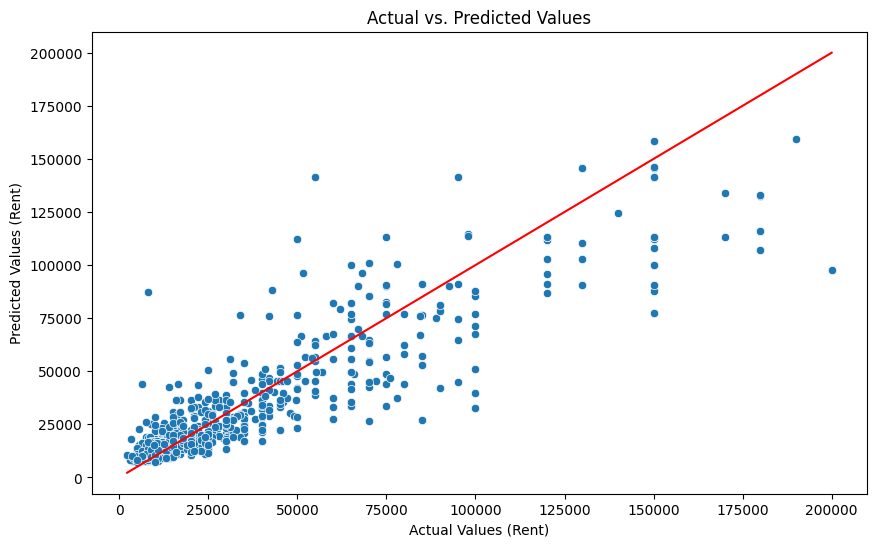

In [218]:
actual_values = y_test
predicted_values = y_pred  

plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual_values, y=predicted_values)
plt.xlabel("Actual Values (Rent)")
plt.ylabel("Predicted Values (Rent)")
plt.title("Actual vs. Predicted Values")

plt.plot([min(actual_values), max(actual_values)], 
         [min(actual_values), max(actual_values)], color='red')
plt.show()

### Feature Importance

In [219]:
features_imp = gbr_model.feature_importances_
importance = sorted(zip(features_imp, X_train.columns), reverse=True)
for imp, feat in importance:
    print(feat, ":", round(imp, 3))

Size_RBS : 0.456
City : 0.376
Bathroom : 0.1
Area Type : 0.024
Furnishing Status : 0.023
BHK : 0.015
Tenant Preferred : 0.006


Apparently, the size of a property (Size_RBS) is a whopping 44.6% important when predicting house rents. I mean, who would have thought that the physical dimensions of a house would matter, right?

And let's not forget the sheer brilliance of "City" at 38.4% importance. Clearly, the location of a property is just a minor detail when it comes to predicting rent prices.

Bathroom, with its earth-shattering 9.4% importance, proves that the number of bathrooms is the true key to the universe.

Area Type, BHK, Furnishing Status, and Tenant Preferred, well, they're just there to keep the other features company, right?

In conclusion, our feature importance analysis has unlocked the deepest secrets of the universe, and we can now confidently say that the size of a property reigns supreme in the mystical realm of house rent prediction. Size matters, folks!

In [220]:
results = pd.DataFrame({'Actual': actual_values, 'Predicted': predicted_values})
results = results.round(0)

In [221]:
results

,Actual,Predicted
3147,8000,9399.0
3827,8500,9031.0
328,7000,9238.0
1246,72000,45549.0
154,7000,8936.0
...,...,...
1538,30000,13169.0
1943,24000,19255.0
166,8000,16714.0
3915,11000,13047.0


Lmao this very poor af!!